In [43]:
import pandas as pd
import numpy as np
import os
from src.data.process_dataset import load_csv_dataset, create_grid, create_grid_ids, correlation_adjacency_matrix, features_targets_and_externals, Dataset
from src.data.encode_externals import encode_times
from src.models.models import ExternalLSTM, GraphModel, CustomTemporalSignal, Encoder, Decoder, STGNNModel
from src.models.baselines import historical_average
from torch_geometric_temporal.signal import StaticGraphTemporalSignal, temporal_signal_split
import dill
from torch_geometric_temporal.nn.recurrent import DCRNN
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.data import Batch, DataLoader
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
open_file = open("/Users/theisferre/Documents/SPECIALE/Thesis/data/processed/202106-citibike-tripdata.pkl", "rb")
dataset = dill.load(open_file)
train_dataset, test_dataset = Dataset.train_test_split(dataset, num_history=8)

In [6]:
num_nodes = dataset.num_nodes
num_features = dataset.num_features
num_weather_features = dataset.weather_information.shape[1]
num_time_features = dataset.time_encoding.shape[1]
node_hidden_features = 6
hidden_size = 16

In [7]:
graph_model = GraphModel(node_in_features=num_features, num_nodes=num_nodes, node_out_features=node_hidden_features)
weather_model = ExternalLSTM(num_weather_features, out_features=node_hidden_features, num_nodes=num_nodes, external_feat="weather", hidden_size=hidden_size)
time_model = ExternalLSTM(num_time_features, out_features=node_hidden_features, num_nodes=num_nodes, external_feat="time_encoding", hidden_size=hidden_size)

In [8]:
snapshot = train_dataset[-1]
cell_state_graph, hidden_state_graph = graph_model(snapshot)
cell_state_weather, hidden_state_weather = weather_model(snapshot)
cell_state_time, hidden_state_weather = time_model(snapshot)

In [9]:
print(f"graph model shapes: {cell_state_graph.shape}, {hidden_state_graph.shape}")
print(f"weather model shapes: {cell_state_weather.shape}, {hidden_state_weather.shape}")
print(f"time model shapes: {cell_state_time.shape}, {hidden_state_weather.shape}")

graph model shapes: torch.Size([1, 600]), torch.Size([1, 600])
weather model shapes: torch.Size([1, 600]), torch.Size([1, 600])
time model shapes: torch.Size([1, 600]), torch.Size([1, 600])


In [10]:
train_data_list = []
for i in range(len(train_dataset)):
    train_data_list.append(train_dataset[i])
train_loader = DataLoader(train_data_list, batch_size=16, shuffle=True)

test_data_list = []
for i in range(len(test_dataset)):
    test_data_list.append(test_dataset[i])
test_loader = DataLoader(test_data_list, batch_size=16, shuffle=True)

In [11]:
encoder = Encoder(
    node_in_features=num_features,
    num_nodes=num_nodes,
    node_out_features=node_hidden_features,
    time_features=num_time_features,
    weather_features=num_weather_features,
    hidden_size=hidden_size
)

decoder = Decoder(
    node_out_features=node_hidden_features,
    num_nodes=num_nodes
)

model = STGNNModel(encoder, decoder).to(DEVICE)

In [12]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=1e-1)
train_losses = []
test_losses = []

for EPOCH in range(200):
    model.eval()
    test_loss = 0
    num_batch_test = 0
    for batch in test_loader:
        out, (hidden, cell) = model(batch.to(DEVICE))
        test_loss += criterion(batch.y, out.view(-1, num_nodes)).item()
        num_batch_test += 1

    
    model.train()
    train_loss = 0
    num_batch_train = 0
    for batch in train_loader:
        out, (hidden, cell) = model(batch.to(DEVICE))

        loss = criterion(batch.y, out.view(-1, num_nodes))
        train_loss += loss.item()
        num_batch_train += 1
        # for demonstration purpose lets just use batchsize=1
        # TODO: IMPLEMENT BATCHSIZE
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss = train_loss/(num_batch_train)
    train_losses.append(np.sqrt(train_loss))

    test_loss = test_loss/(num_batch_test)
    test_losses.append(np.sqrt(test_loss))


    if EPOCH % 1 == 0:
        
        print(f"Epoch number {EPOCH+1}")
        print(f"Epoch avg RMSE loss (TRAIN): {train_losses[-1]}")
        print(f"Epoch avg RMSE loss (TEST): {test_losses[-1]}")
        print("-"*10)

Epoch number 1
Epoch avg RMSE loss (TRAIN): 0.755768825003966
Epoch avg RMSE loss (TEST): 0.8418755844858052
----------


KeyboardInterrupt: 

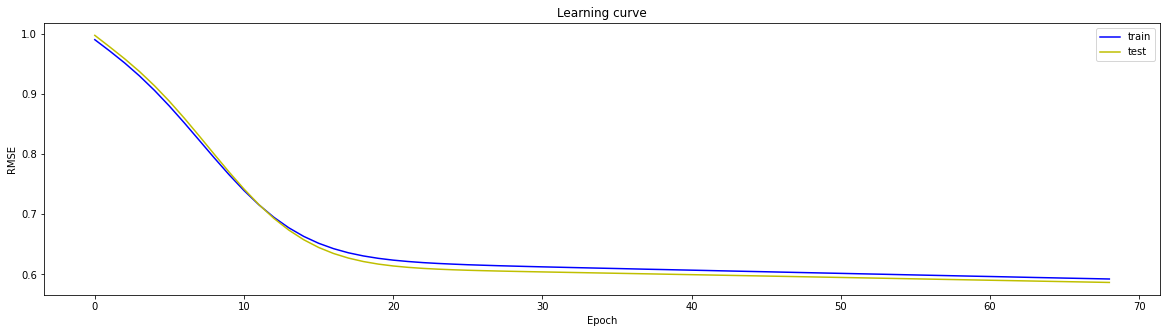

In [11]:
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(train_losses, c="b", label="train")
plt.plot(test_losses, c="y", label="test")
plt.ylabel("RMSE")
plt.xlabel("Epoch")
plt.title("Learning curve")
plt.legend()
plt.show()

In [12]:
with torch.no_grad():
    train_errs_node = np.zeros(num_nodes)
    for snapshot in train_dataset:
        out, (hidden, cell) = model(snapshot)
        pred = dataset.target_scaler.inverse_transform(out.view(-1))
        y_reversed = dataset.target_scaler.inverse_transform(snapshot.y)
        train_errs_node += (y_reversed - pred)**2

    train_errs_node = train_errs_node / len(train_dataset)


    test_errs_node = np.zeros(num_nodes)
    for snapshot in test_dataset:
        out, (hidden, cell) = model(snapshot)
        pred = dataset.target_scaler.inverse_transform(out.view(-1))
        y_reversed = dataset.target_scaler.inverse_transform(snapshot.y)
        test_errs_node += (y_reversed - pred)**2

    test_errs_node = test_errs_node / len(test_dataset)

In [13]:
stacked_errs = np.stack([train_errs_node, test_errs_node], -1)
node_level_errs_df = pd.DataFrame(stacked_errs, columns=["Train Errors", "Test Errors"])

<AxesSubplot:title={'center':'Node-level MSE'}, xlabel='node (region)', ylabel='MSE'>

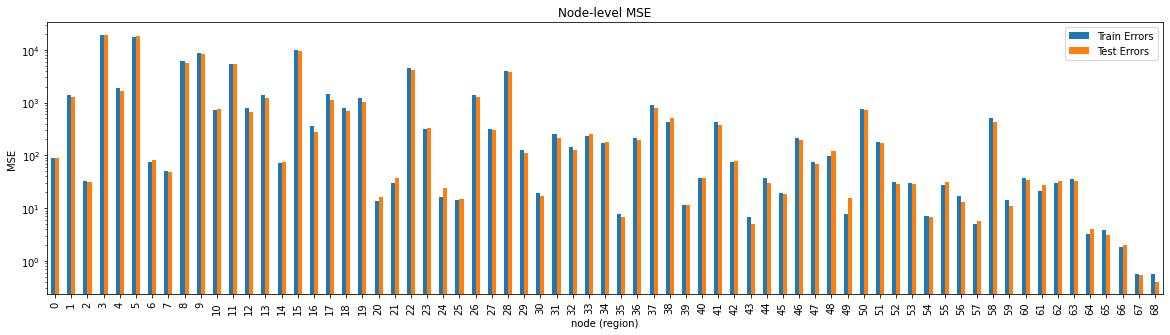

In [14]:
node_level_errs_df.plot.bar(xlabel="node (region)", ylabel="MSE", title="Node-level MSE", log=True)

In [23]:
np.sqrt(stacked_errs[:, 0].mean())

36.88498810782282

# HISTORICAL AVERAGE BASELINE

In [54]:
HA_MSE = historical_average(train_dataset, test_dataset)
print(f"Historical Average MSE on Test dataset: {HA_MSE}")

Historical Average MSE on Test dataset: 0.7057307362556458
